# Training VTB Classifier using Google BigTransfer (BiT)

In [1]:
# OS
from random import seed
from random import random
from random import sample
import random as random
import os
import errno
from datetime import datetime
import logging

# to load weights from cloud bucket
import requests
import io

# Image processing and graphing
import PIL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# ML/Science libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision as tv
from torch.utils.data import Dataset, DataLoader

# other
from functools import partial
from collections import OrderedDict

In [2]:
# setting device to GPU

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


# Reading weight data from localized NPZ file

These can be downaloded from https://storage.googleapis.com/bit_models/{bit_variant}.npz
where {bit_variant} is BiT-M-R152x2 or similar depending on desired model

In [3]:
def get_weights(bit_variant):
    f = open(f'../BiT_models/{bit_variant}.npz', "rb")
    # return np.load(io.BytesIO(f))
    return np.load(io.BufferedReader(f))

# You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.
model_name = 'BiT-M-R50x1'
weights = get_weights(model_name) 

# Defining the architecture and loading weights

In [4]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [5]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [6]:
class ResNetV2(nn.Module):
#   BLOCK_UNITS = {
#       'r50': [3, 4, 6, 3],
#       'r101': [3, 4, 23, 3],
#       'r152': [3, 8, 36, 3],
#   }

  BLOCK_UNITS = {
      'r50': [3, 4, 4, 2],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }


  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

# Boilerplate

In [7]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [8]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

In [9]:
# splits list into num parts for crossvalidation
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [10]:
# creates folder with timestamp as name

def create_folder():
    mydir = os.path.join(
        os.path.abspath(os.getcwd()), "training",
        datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise  # This was not a "directory exist" error..
    return mydir

In [11]:
# INITIALIZING TRAINING FOLDER AND LOG FILE

wd = create_folder()
logfile = open(os.path.join(wd, "training.log"),"a")
# logfile.write('Training Model: %s\n' %  model_name)
# logfile.flush()

In [12]:
# Setting training parameters

image_size = 400

# path to data files
# data_path = os.path.join(os.path.abspath(os.getcwd()),"../images/images_annotations_for_training/scaled/")

# path to data files
data_path = os.path.join(os.path.abspath(os.getcwd()),"../images/images_annotations_for_training/400px/")


#setting data type
dtype = torch.float32 

# training on transverse images only
transverse_only = False

# Number of images to pull from cine clips
how_many = 0

# Should cine clip images for training be randomly selected for each epoch
random_cine = True

# Defines model to train
benign_vs_malignant = True

# if True grayscale images will be converted to plsuedo RGB by copying grayscale channel 3 times
pseudo_RGB = True

# if true, cine clip will be trimmed to manually annotated [start, stop) frames
# this is to avoid training and inference on very early and very late frames that may no contain 
#much of the nodule
extract_annotated_frames = True


# Mini-batch size
batch_size = 256



In [13]:
# Defining Dataset Class that will handle thyroid images
# Instead of loading images from folder, connecting it to the list of preloaded, resized and normalized images

class ThyroidNoduleDataset(Dataset): # inherits from PyTorch Dataset

    def __init__(self, image_classes, data_array, train=True, transform=None):

        self.image_classes = image_classes
        self.data_array = data_array
        self.train = train
        self.transform = transform
        
    def __len__(self): # returns length of the Dataset (required)
        return self.data_array.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # returns tuple of (Tensor(image), image_class)
            idx = idx.tolist()
            
        image = self.data_array[idx,:,:,:]  
        #image = torch.from_numpy(np.expand_dims(image, axis=0)) # Tensor has shape of []
        
        image_class = int(self.image_classes[idx])
        
        if self.transform:
            image = self.transform(image)

        sample = (image, image_class)
        return sample

# DYNAMIC AUGMENTATION
# creating Datasets for training, validation and testing and initializing loader

# batch_size = X_train.shape[0]



preprocess_train = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize((image_size, image_size), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    # tv.transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1), scale=(0.9, 1.2), shear=(-3,3)),
    tv.transforms.RandomAffine(degrees = 0, translate=(0, 0), scale=(0.8, 1.2), shear=(-3,3)),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize((image_size, image_size), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading Thyroid US Images for training

In [14]:
# # this function gets cine clip annotations and images and returns 'how_many' evenly spaced frames

# def get_evenly_spaced_cine_clip_frames(anno_cineclip, images_cineclip, how_many):
    
#     cineclip_IDs = anno_cineclip['comboID'].unique()

#     # getting the first clip data
#     anno_cc = anno_cineclip[anno_cineclip['comboID'] == cineclip_IDs[0]]
#     images_cc = images_cineclip[anno_cineclip['comboID'] == cineclip_IDs[0]]
    
    
#     # getting how_many evenly spaced cine clip frame extracts for training into a separate subset
#     idx = np.round(np.linspace(0, anno_cc.shape[0] - 1, how_many+2)).astype(int)
#     anno_cineclip_evenly_spaced = anno_cc.iloc[idx[1:-1]] # fist and last images not included
#     images_cineclip_evenly_spaced = images_cc[idx[1:-1]]

#     # iterating through the remainder of nodules
#     for i in range(1, len(cineclip_IDs)):
        
#         anno_cc = anno_cineclip[anno_cineclip['comboID'] == cineclip_IDs[i]]
#         images_cc = images_cineclip[anno_cineclip['comboID'] == cineclip_IDs[i]]
                
#         idx = np.round(np.linspace(0, anno_cc.shape[0] - 1, how_many+2)).astype(int)
#         anno_cc_evenly_spaced = anno_cc.iloc[idx[1:-1]] # fist and last images not included
#         images_cc_evenly_spaced = images_cc[idx[1:-1]]

#         anno_cineclip_evenly_spaced = pd.concat((anno_cineclip_evenly_spaced, anno_cc_evenly_spaced), axis = 0)
#         images_cineclip_evenly_spaced = np.concatenate((images_cineclip_evenly_spaced, images_cc_evenly_spaced), axis = 0)

#     return anno_cineclip_evenly_spaced, images_cineclip_evenly_spaced

In [15]:
# def get_randomly_selected_cine_clip_frames(anno_cineclip, images_cineclip, how_many):
    
#     cineclip_IDs = anno_cineclip['comboID'].unique()
    
#     # initializing empty pandas df and numpy array to store annotations and images, respectively
#     anno_cineclip_randomly_selected = anno_cineclip[0:0]
#     images_cineclip_randomly_selected = np.empty((0,image_size,image_size), dtype = 'uint8')

#     for i in range(len(cineclip_IDs)):
        
#         anno_cc = anno_cineclip[anno_cineclip['comboID'] == cineclip_IDs[i]]
#         images_cc = images_cineclip[anno_cineclip['comboID'] == cineclip_IDs[i]]
        
#         if anno_cc.shape[0] > how_many:
#             random_int = random.sample(range(0, anno_cc.shape[0]-1), how_many)  
            
#             anno_cineclip_randomly_selected = pd.concat((anno_cineclip_randomly_selected, anno_cc.iloc[random_int]), axis = 0)
#             images_cineclip_randomly_selected = np.concatenate((images_cineclip_randomly_selected, images_cc[random_int]), axis = 0)


#     return anno_cineclip_randomly_selected, images_cineclip_randomly_selected

In [16]:
def get_randomly_selected_cine_clip_frames(anno_cineclip, images_cineclip, how_many):
    
    cineclip_IDs = anno_cineclip['comboID'].unique()
    

    frames_list = []
    
    for i in range(len(cineclip_IDs)):
        tmp = anno_cineclip[anno_cineclip['comboID'] == cineclip_IDs[i]]

        tf = [False for i in range(tmp.shape[0])]

        if tmp.shape[0] > how_many:
            random_int = random.sample(range(0, tmp.shape[0]-1), how_many)  

            for n in range(len(random_int)):   
                tf[random_int[n]] = True

        frames_list.extend(tf)

    return anno_cineclip[frames_list], images_cineclip[frames_list]

In [17]:
# MERGING WITH CINE CLIPS
# the function merges combined trasnverse and longitudinal static image data with frames extracted from cine_clips
# 'how_many' defines how many images are extracted from each nodule (transverse and longitudinal cine clips
# are combined so )


def merging_images(anno_transverse, images_transverse, anno_longitudinal, images_longitudinal, \
                         anno_cineclip_transverse, images_cineclip_transverse, \
                         anno_cineclip_longitudinal, images_cineclip_longitudinal, \
                         how_many, random_cine, pseudo_RGB, extract_annotated_frames, \
                         transverse_only):
    
    if transverse_only:
        anno_original = anno_transverse
        all_unique_comboIDs = np.unique(anno_original['comboID'])
        images_original = images_transverse    
    else:
    
        # getting unique comboIDs from static transverse and longitudinal images
        # merging static trasnverse and longitudinal images; saving as -nc for inference
        anno_original = pd.concat((anno_transverse, anno_longitudinal), axis = 0)
        all_unique_comboIDs = np.unique(anno_original['comboID'])
        images_original = np.concatenate((images_transverse, images_longitudinal), axis = 0)
    
    anno_original_nc = anno_original
    images_original_nc = images_original

    # processing cine clip data 
    if how_many > 0:
        if random_cine == False: # this is a case when evenly spaced cine clip frames will be served
            anno_cc_trans, images_cc_trans = get_evenly_spaced_cine_clip_frames(anno_cineclip_transverse, \
                                                                                images_cineclip_transverse, \
                                                                                how_many=how_many)
            
            anno_cc_long, images_cc_long = get_evenly_spaced_cine_clip_frames(anno_cineclip_longitudinal, \
                                                                                images_cineclip_longitudinal, \
                                                                                how_many=how_many)
        else: # selecting how_many frames randomly
            anno_cc_trans, images_cc_trans = get_randomly_selected_cine_clip_frames(anno_cineclip_transverse, \
                                                                                images_cineclip_transverse, \
                                                                                how_many=how_many)
            
            anno_cc_long, images_cc_long = get_randomly_selected_cine_clip_frames(anno_cineclip_longitudinal, \
                                                                                images_cineclip_longitudinal, \
                                                                                how_many=how_many)
            
    
    
        anno_original = pd.concat((anno_transverse, anno_longitudinal, anno_cc_trans, anno_cc_long), axis = 0)
        images_original = np.concatenate((images_transverse, images_longitudinal, images_cc_trans, \
                                          images_cc_long), axis = 0)        
     
    
    if pseudo_RGB == True:
        
        images_original_nc = np.expand_dims(images_original_nc, axis= 3)
        images_original_nc = np.concatenate((images_original_nc, images_original_nc, images_original_nc), \
                                            axis= 3)
        images_original = np.expand_dims(images_original, axis= 3)
        images_original = np.concatenate((images_original, images_original, images_original), axis= 3)
        
        
        
    if benign_vs_malignant == True: # select only nodules with class 0 or 1
        
        # subsetting annotations and images to include benign and malignant classes (removing indeterminates and those unable to classify as benign or malignant)
        anno_subset = anno_original[np.logical_or(anno_original['class'] == 1, \
                                                  anno_original['class'] == 0)]
        images_subset = images_original[np.logical_or(anno_original['class'] == 1, \
                                                      anno_original['class'] == 0),:,:,:]

        # no cine clip images for validation
        anno_subset_nc = anno_original_nc[np.logical_or(anno_original_nc['class'] == 1, \
                                                        anno_original_nc['class'] == 0)]
        images_subset_nc = images_original_nc[np.logical_or(anno_original_nc['class'] == 1, \
                                                            anno_original_nc['class'] == 0),:,:,:]
    else: # no subsetting is done
        anno_subset = anno_original
        images_subset = images_original
        anno_subset_nc = anno_original_nc
        images_subset_nc = images_original_nc


    all_nodules = list(anno_subset['comboID'].unique())
    
    return anno_subset_nc, images_subset_nc, anno_subset, images_subset, all_nodules
    

    

In [18]:
# extracting frames from the nodule as manually annotated (start frame included, stop frame is not included)
# which cine is either 'trans_start_stop' for trasnverse cine clips or 'long_start_stop'
# needed as annotations are stored in different columns in annotation data frame

def get_annotated_cine_clip_frames(anno_cineclip, images_cineclip):
    
    images_cineclip = images_cineclip[anno_cineclip['curated_frame'] == 'Yes']
    anno_cineclip = anno_cineclip[anno_cineclip['curated_frame'] == 'Yes']

    anno_cineclip.rename(columns = {'frame':'frame_number'}, inplace = True) # for compatibility with older code
    
    return anno_cineclip, images_cineclip

In [19]:
# LOADING TRANSVERSE AND LONGITUDINAL IMAGES THAT HAVE BEEN MANUALLY CURATED AND ARTIFACTS REMOVED

images_transverse = np.load(os.path.join(data_path, "images_transverse.npy"), allow_pickle = True)
images_transverse = images_transverse.astype('uint8')
images_transverse = images_transverse[:,:,:,0] # grayscale
anno_transverse = pd.read_pickle(os.path.join(data_path, "anno_transverse.pkl"))

images_longitudinal = np.load(os.path.join(data_path, "images_longitudinal.npy"), allow_pickle = True)
images_longitudinal = images_longitudinal.astype('uint8')
images_longitudinal = images_longitudinal[:,:,:,0] # grayscale
anno_longitudinal = pd.read_pickle(os.path.join(data_path, "anno_longitudinal.pkl"))

images_cineclip_trans = np.load(os.path.join(data_path, "images_transverse_cine.npy"), allow_pickle = True)
images_cineclip_trans = images_cineclip_trans.astype('uint8')
anno_cineclip_trans = pd.read_pickle(os.path.join(data_path, "anno_transverse_cine.pkl"))

images_cineclip_long = np.load(os.path.join(data_path, "images_longitudinal_cine.npy"), allow_pickle = True)
images_cineclip_long = images_cineclip_long.astype('uint8')
anno_cineclip_long = pd.read_pickle(os.path.join(data_path, "anno_longitudinal_cine.pkl"))

# rotating images 90% clockwise
images_transverse = np.rot90(images_transverse, k=3, axes=(1, 2))
images_longitudinal = np.rot90(images_longitudinal, k=3, axes=(1, 2))
images_cineclip_trans = np.rot90(images_cineclip_trans, k=3, axes=(1, 2))
images_cineclip_long = np.rot90(images_cineclip_long, k=3, axes=(1, 2))



if extract_annotated_frames:
    anno_cineclip_trans, images_cineclip_trans = get_annotated_cine_clip_frames(anno_cineclip_trans, \
                                                                                images_cineclip_trans)
    
    anno_cineclip_long, images_cineclip_long = get_annotated_cine_clip_frames(anno_cineclip_long, \
                                                                                images_cineclip_long)
    
# creating copy image set and expanding dims for inference on cine clip frames

images_cineclip_trans_for_inference = np.repeat(images_cineclip_trans[:, :, :, np.newaxis], 3, axis=3)
images_cineclip_long_for_inference = np.repeat(images_cineclip_long[:, :, :, np.newaxis], 3, axis=3)   

/home/nikitos/anaconda3/envs/vtb/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [20]:
%%time
anno_subset_nc, images_subset_nc, anno_subset, images_subset, all_nodules = merging_images(anno_transverse, \
                                            images_transverse, anno_longitudinal, \
                                            images_longitudinal, anno_cineclip_trans, images_cineclip_trans, \
                                            anno_cineclip_long, images_cineclip_long, \
                                            how_many = how_many, random_cine = random_cine, \
                                            pseudo_RGB = pseudo_RGB, \
                                            extract_annotated_frames = extract_annotated_frames, \
                                            transverse_only = transverse_only)

CPU times: user 632 ms, sys: 176 ms, total: 808 ms
Wall time: 808 ms


In [21]:
len(all_nodules)

621

In [31]:
anno_subset.shape

(1233, 9)

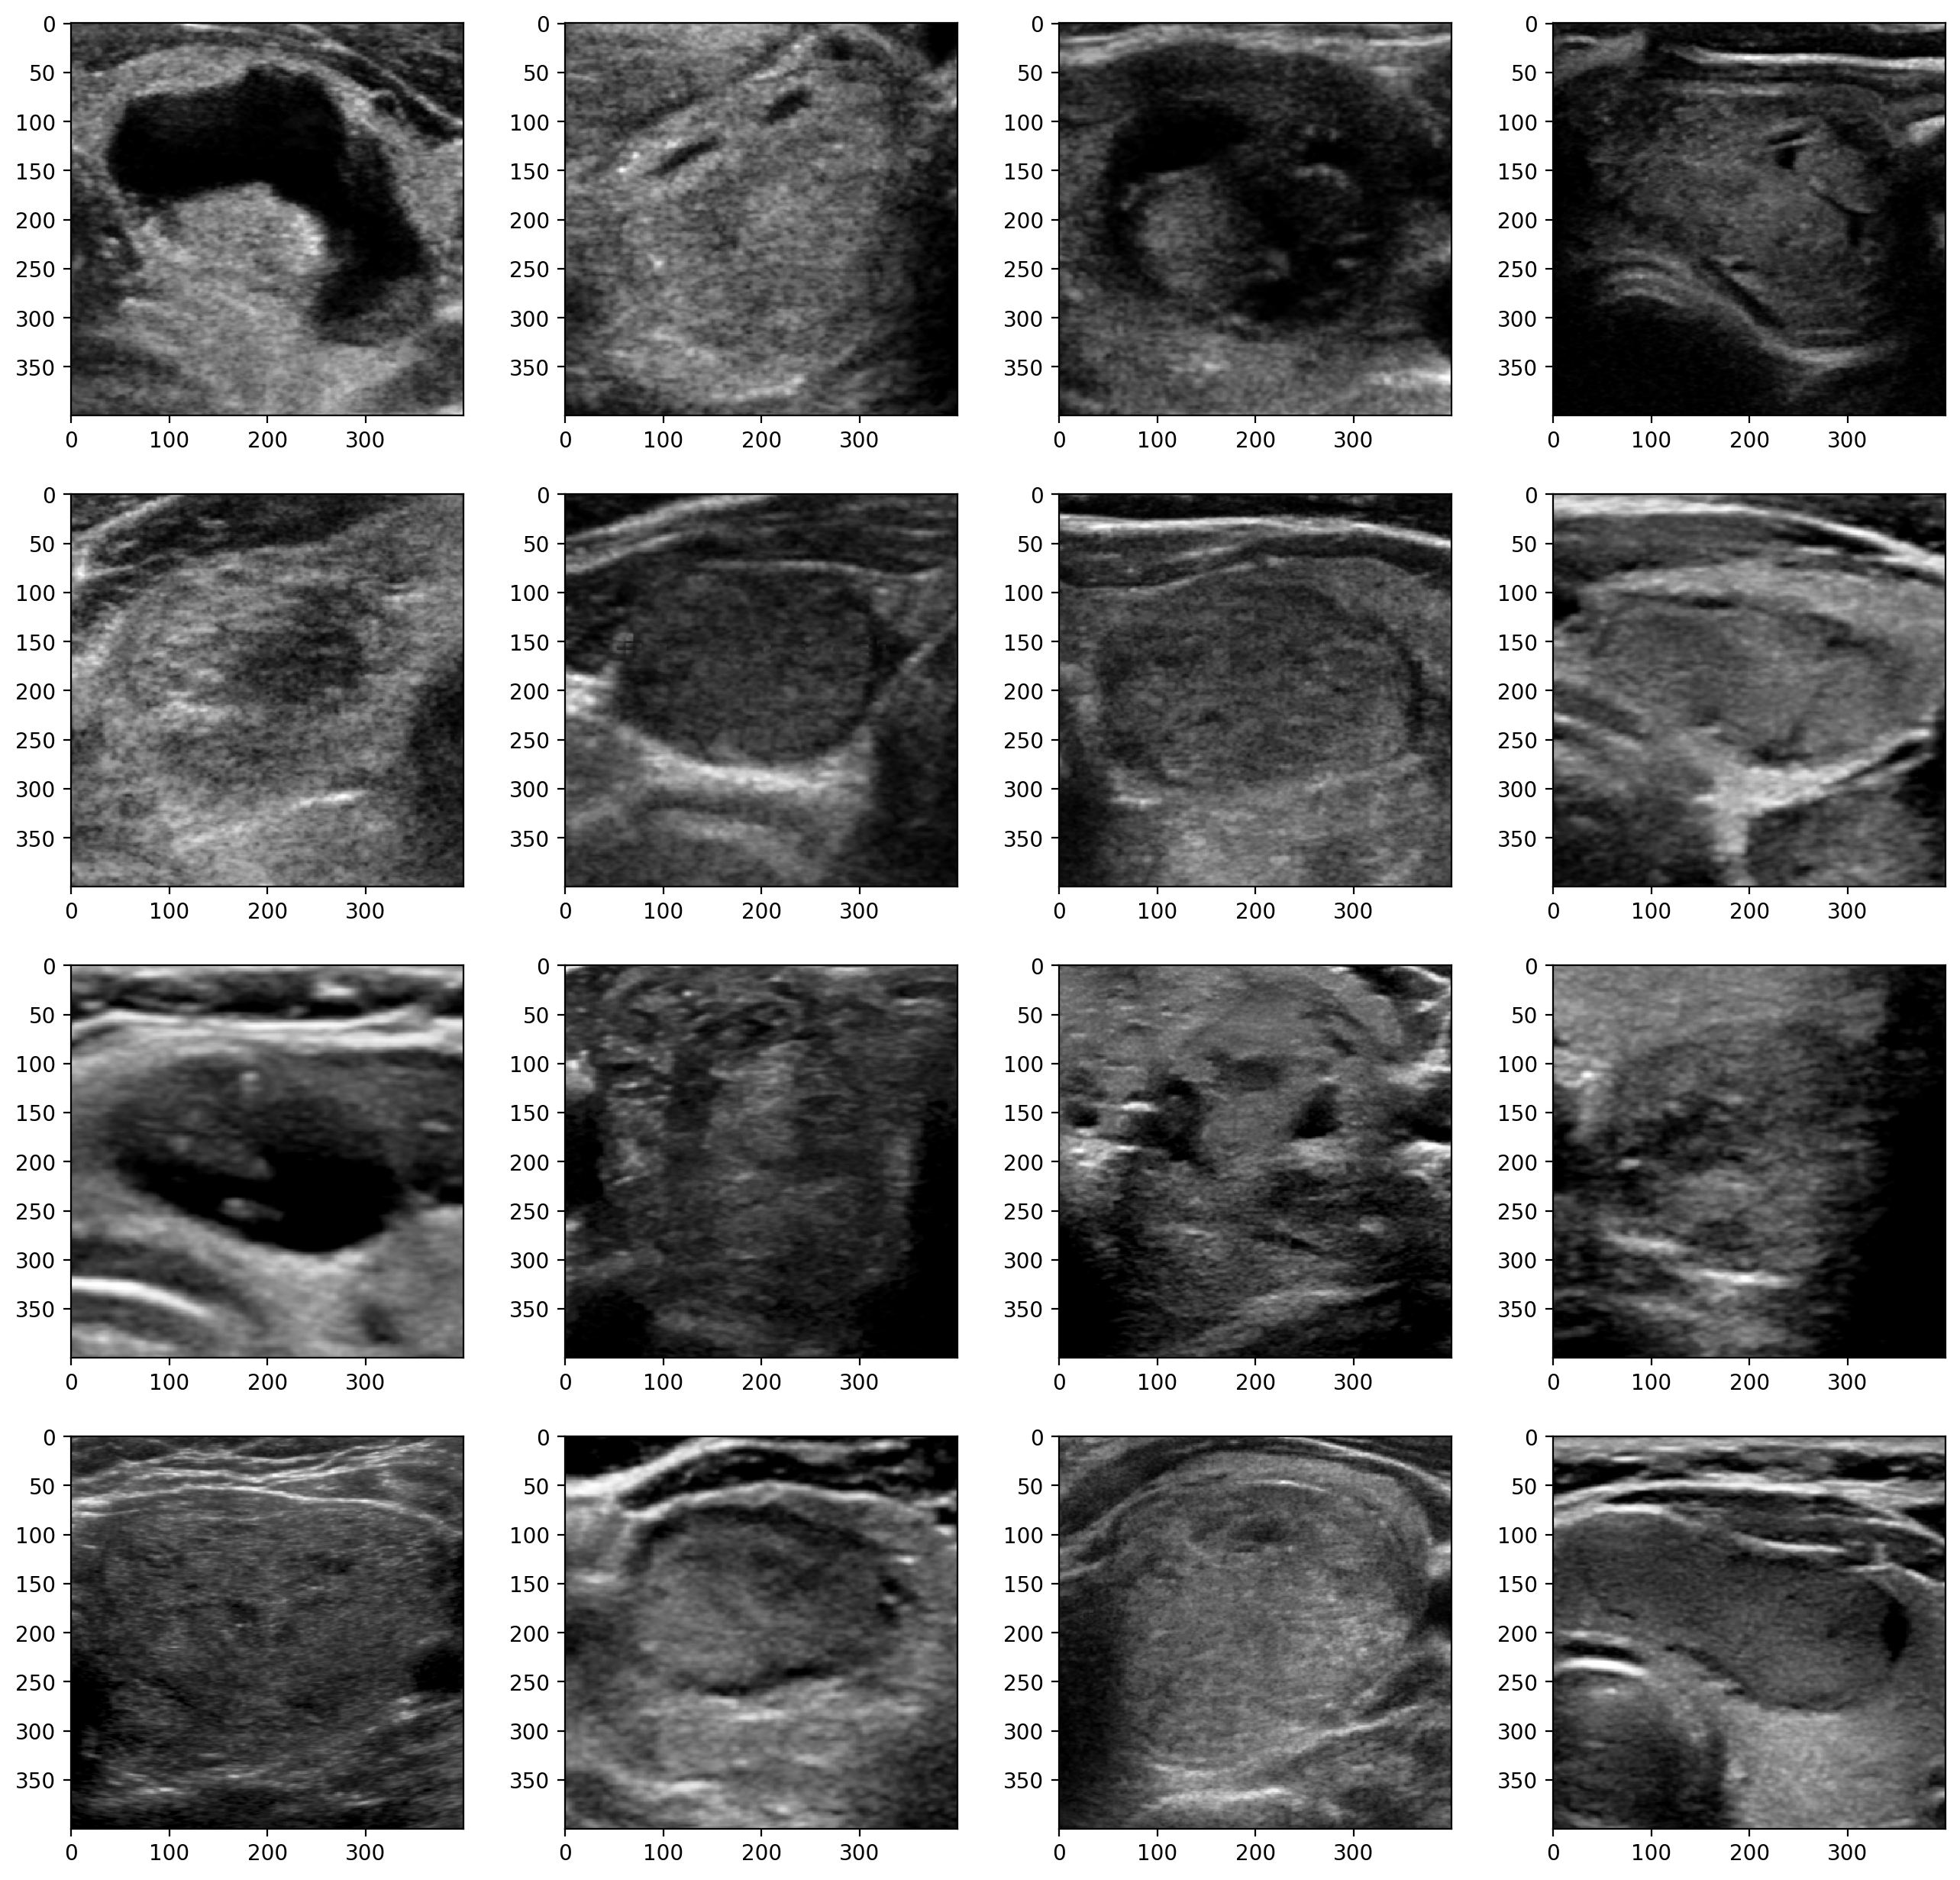

In [32]:
plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
for i in range(16):
    plt.subplot(8,4,i+1)
    plt.imshow(np.array(images_subset[i+520,:,:,0]), cmap='gray', interpolation='none')

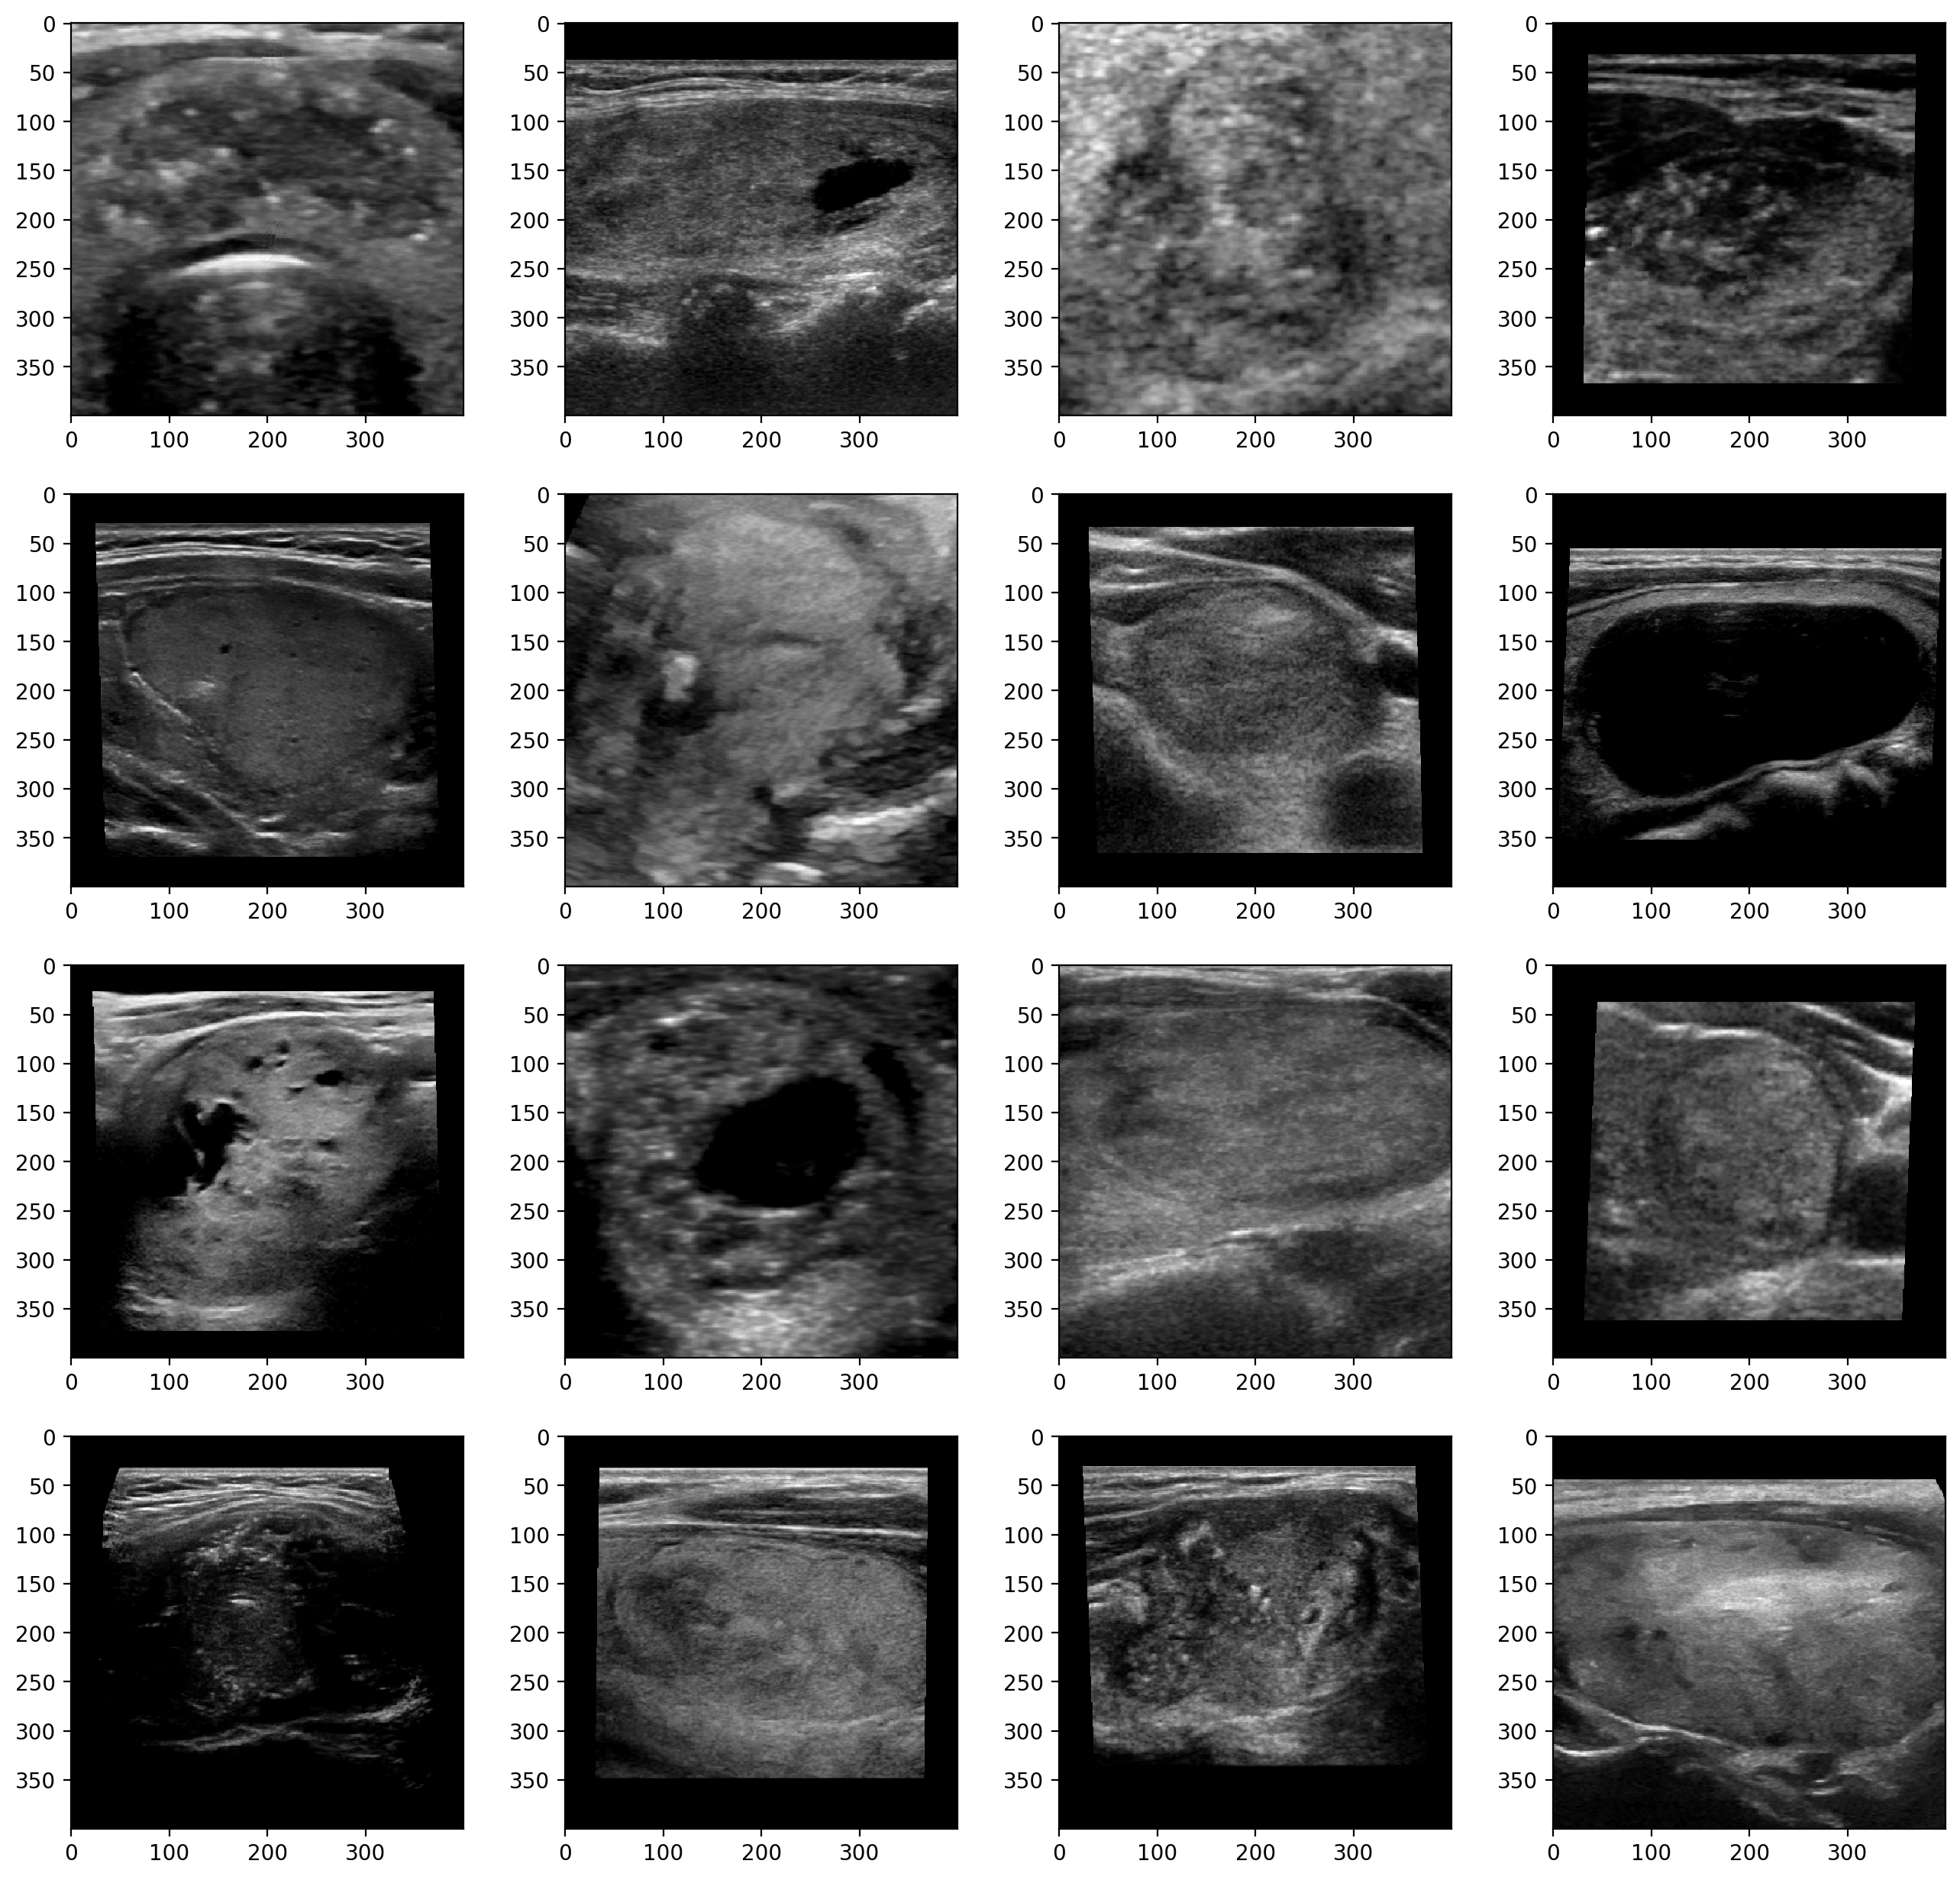

In [33]:
# to test image loaders and transformations
all_test = ThyroidNoduleDataset(image_classes=anno_subset['class'].tolist(), data_array=images_subset, train=True, transform=preprocess_train)
loader_test = DataLoader(all_test, batch_size=batch_size, shuffle = True)

for x, y in loader_test:

    plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
    for i in range(16):
        #print(x.shape)
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(x[i+1,0,:,:]), cmap='gray', interpolation='none')
    break

In [34]:
# # randomly splitting nodule IDs between train, validation and test datasets
# there are 386 benign/malignant nodules (less than 398 rows in 'anno_transverse_subset')
# this is becasue there are few RData files with longitudinal cine clips that also contain transverse images

# randomly distributing nodules: 250 for training, 86 for validation and 50 for testing
random.seed(32)
all_nodules = list(anno_subset['comboID'].unique())
random.shuffle(all_nodules)

CVsplits = chunkIt(all_nodules, 5)

logfile.write('Crossvalidation splits: %s\n' %  CVsplits)
logfile.flush()

In [35]:
def eval_model_cineclips(model, loader, loss_function, image_IDs):
  
    model.eval() #switches model to evaluation mode

    with torch.no_grad():
  
        epoch_loss = [] # this list will accumulate losses for mini batches
        epoch_predictions = [] # this list accumulates predictions across batches
        epoch_probabilities = np.empty((0,2)) # accumulates softmax probabilities of benign and malignant classes
        
        ground_truth = np.empty((0)) # list for actual values of y
        
        
        for x, y in loader:
            x, y = x.to(device), y.to(device)
      
            logits = model(x)
            epoch_loss.append(loss_function(logits, y).item())
            epoch_predictions.extend(torch.max(logits, dim=1)[1].cpu().numpy() == y.cpu().numpy())
    
      
            # applying softmax calssifier to get probabilities of classes (added to 1)
            sm = nn.Softmax(dim=1)
            epoch_probabilities = np.concatenate((epoch_probabilities, np.array(sm(logits).cpu())), axis = 0)  
         
            ground_truth = np.concatenate((ground_truth, np.array(y.cpu())), axis = 0)
            
        predictions = pd.DataFrame({'Nodule': image_IDs, # make sure that DataLoader has shuffle set to false
                                    'Class':ground_truth, 
                                    'Prediction': epoch_predictions,
                                    'P_benign': epoch_probabilities[:,0], 
                                    'P_malignant': epoch_probabilities[:,1]})

        # calculating false positive and flase negative rates and AUROC
        fpr, tpr, _ =roc_curve(ground_truth, epoch_probabilities[:,1])
        roc_auc = auc(fpr, tpr)
        
        
        # SUMMARIZING PREDICTION BY NODULE
        # averaging predictions from transverse and longitudinal image and recalculating ROC

        prob_benign_nodule = []
        prob_malign_nodule = []
        nodule_class = []
        predicted_class = []

        nod = predictions['Nodule'].unique()

        for i in nod:
            prob_benign_nodule.append(predictions[predictions['Nodule'] == i]['P_benign'].mean())
            prob_malign_nodule.append(predictions[predictions['Nodule'] == i]['P_malignant'].mean())
            nodule_class.append(predictions[predictions['Nodule'] == i]['Class'].mean().astype('int32'))

            if predictions[predictions['Nodule'] == i]['P_benign'].mean() > predictions[predictions['Nodule'] == i]['P_malignant'].mean():
                predicted_class.append(0)
            else:
                predicted_class.append(1)

        by_nodule = pd.DataFrame({'Nodule': nod, 'Class': nodule_class, 'Prediction': predicted_class,
                                  'Prob_benign_by_nodule': prob_benign_nodule,
                                  'Prob_malign_by_nodule': prob_malign_nodule})    



        # calculating false positive and flase negative rates and AUROC
        fpr_nod, tpr_nod, _ =roc_curve(by_nodule['Class'], by_nodule['Prob_malign_by_nodule'])
        roc_auc_nodule = auc(fpr_nod, tpr_nod)
      
    
    
    return [np.mean(epoch_loss), np.mean(epoch_predictions), roc_auc, roc_auc_nodule, 
            predictions, by_nodule, fpr, tpr, fpr_nod, tpr_nod]

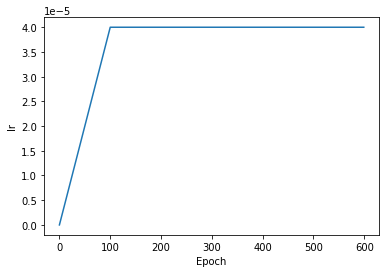

In [37]:
S = 600

logfile.write('Mini batch size: %s\n' %  S)
logfile.flush()

def schedule(s): # defines learning rate schedule
  
    # training schedule for combined transverse and longitudinals
    # best schedule for full BiT r50
    #step_lr = stairs(s, 1.0e-5, 200, 1.3e-5, 300, 1.6e-5, 400, 2e-5, S, 1e-5)

    # svchedule for transverse only
    step_lr = stairs(s, 4.0e-5, 100, 4e-5, S, 1e-4)
    
    return rampup(s, 100, step_lr)

plt.plot(range(S), list(map(schedule, range(S))))
plt.ylabel("lr")
plt.xlabel("Epoch")
plt.savefig(os.path.join(wd, "learning_rate_schedule.pdf"))

In [ ]:
# VERSION OF THE TRAINING LOOP THAT ALSO DOES INFERENCE ON CINE CLIPS
# for k in range(4,5):
for k in range(len(CVsplits)):
    thyroid_val = CVsplits[k]
    thyroid_train = [i for i in all_nodules if i not in CVsplits[k]]

    # ADDING CINE CLIP IMAGES
    Y_train = list(anno_subset["class"][anno_subset['comboID'].isin(thyroid_train)])
    X_train = images_subset[anno_subset['comboID'].isin(thyroid_train),:,:,:]
    Y_train_nodule_ID = list(anno_subset["comboID"][anno_subset['comboID'].isin(thyroid_train)])

    # validation and test images are selected from the original image set that does not have cine clip images
    Y_val = list(anno_subset_nc["class"][anno_subset_nc['comboID'].isin(thyroid_val)])
    X_val = images_subset_nc[anno_subset_nc['comboID'].isin(thyroid_val),:,:,:]
    Y_val_nodule_ID = list(anno_subset_nc["comboID"][anno_subset_nc['comboID'].isin(thyroid_val)])
    
    sets_stats = pd.DataFrame([[X_train.mean(), X_train.std(), 
                                sum(list(map(lambda x: x == 0, Y_train)))/len(Y_train) *100],
                               [X_val.mean(), X_val.std(),
                                sum(list(map(lambda x: x == 0, Y_val)))/len(Y_val) * 100]],
                              columns = ['Means', 'StDevs', 'No_information_rate'])
    
    
    logfile.write('\nCrossvalidation split : %s\n' %  (k+1))
    logfile.write('Shape of training dataset : %s\n' %  list(X_train.shape))
    logfile.write('Shape of validation dataset : %s\n' %  list(X_val.shape))
    logfile.write("No information rate train: {}\n".format(sets_stats['No_information_rate'][0]))
    logfile.write("No information rate val: {}\n".format(sets_stats['No_information_rate'][1]))
    logfile.flush()
    
    all_train = ThyroidNoduleDataset(image_classes=Y_train, data_array=X_train, train=True, transform=preprocess_train)
    all_val = ThyroidNoduleDataset(image_classes=Y_val, data_array=X_val, train=True, transform=preprocess_eval)
 
    loader_train = DataLoader(all_train, batch_size=batch_size, shuffle = True)
    loader_val = DataLoader(all_val, batch_size=batch_size, shuffle = False)
 
    ##################################################################################
    # SETTING UP LOADERS FOR INFERENCE ON CINE CLIP FRAMES
    ##################################################################################
    
    # for TRANSVERSE CINE CLIPS
    Y_cine_trans = list(anno_cineclip_trans["class"][anno_cineclip_trans['comboID'].isin(thyroid_val)])
    X_cine_trans = images_cineclip_trans_for_inference[anno_cineclip_trans['comboID'].isin(thyroid_val),:,:,:]

    # for cine clip images IDs concatenating comboID and frame number
    comboIDs_list = list(anno_cineclip_trans["comboID"][anno_cineclip_trans['comboID'].isin(thyroid_val)])
    frame_list = map(str, list(anno_cineclip_trans["frame_number"][anno_cineclip_trans['comboID'].isin(thyroid_val)]))
    Y_cine_trans_image_ID = [i + '_' + j for i, j in zip(comboIDs_list, frame_list)] 

    # loader for inference on cine clips
    all_cine_trans = ThyroidNoduleDataset(image_classes=Y_cine_trans, data_array=X_cine_trans, \
                                          train=False, transform=preprocess_eval)
    loader_cine_trans = DataLoader(all_cine_trans, batch_size=batch_size, shuffle = False)


    
    # for LONGITUDINAL CINE CLIPS
    Y_cine_long = list(anno_cineclip_long["class"][anno_cineclip_long['comboID'].isin(thyroid_val)])
    X_cine_long = images_cineclip_long_for_inference[anno_cineclip_long['comboID'].isin(thyroid_val),:,:,:]

        # for cine clip images IDs concatenating comboID and frame number
    comboIDs_list = list(anno_cineclip_long["comboID"][anno_cineclip_long['comboID'].isin(thyroid_val)])
    frame_list = map(str, list(anno_cineclip_long["frame_number"][anno_cineclip_long['comboID'].isin(thyroid_val)]))
    Y_cine_long_image_ID = [i + '_' + j for i, j in zip(comboIDs_list, frame_list)] 

        # loader for inference on cine clips
    all_cine_long = ThyroidNoduleDataset(image_classes=Y_cine_long, data_array=X_cine_long, \
                                              train=False, transform=preprocess_eval)
    loader_cine_long = DataLoader(all_cine_long, batch_size=batch_size, shuffle = False)

    #############################################################################
    
    
    # this model stores the best performing model during training
    best_model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=2, zero_head=True)
    best_model.load_from(weights)
    best_model = nn.DataParallel(best_model)
    best_model.to(device)

    # TRAINING MODEL
    model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=2, zero_head=True)
    model.load_from(weights)

    # Selecting layers for training
    for param in model.parameters():
        param.requires_grad = False

    ct = 0
    ct_child = 0

    for child in model.children():
        if ct == 1:
             for sub_child in child.children():
                    if ct_child >= 2:
                        for param in sub_child.parameters():
                            param.requires_grad = True                  
                    ct_child = ct_child + 1

        if ct == 2:
            for param in child.parameters():
                param.requires_grad = True
        ct = ct + 1

    model = nn.DataParallel(model)

    model.to(device);

    loss_function = nn.CrossEntropyLoss() # Loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9) # optimizer

#     lr = 2e-7 # lr for Adam
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    pb_train = display(progress(0, S), display_id=True) # initializes progress indicator

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    roc_auc = []
    roc_auc_nod = []

    best_model_epoch = 0

    while len(training_loss) < S:

        model.train(); # sets model to training mode

        batch_loss = [] # this list will accumulate losses for mini batches
        batch_accuracy = [] #this list accumulates predictions across batches

        
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # for each epoch generating new loder_train when 2 images are randomly selected for each nodule
        
        # getting new set of merged inages ('nc' should be exactly same but anno-subset will have random frames
        if how_many > 0 and random_cine == True:
            anno_subset_nc, images_subset_nc, anno_subset, images_subset, all_nodules = merging_images(anno_transverse, \
                                                images_transverse, anno_longitudinal, \
                                                images_longitudinal, anno_cineclip_trans, images_cineclip_trans, \
                                                anno_cineclip_long, images_cineclip_long, \
                                                how_many = how_many, random_cine = random_cine, \
                                                pseudo_RGB = pseudo_RGB, \
                                                extract_annotated_frames = extract_annotated_frames, \
                                                transverse_only = transverse_only)

            # regenerating new training loader
            Y_train = list(anno_subset["class"][anno_subset['comboID'].isin(thyroid_train)])
            X_train = images_subset[anno_subset['comboID'].isin(thyroid_train),:,:,:]
            Y_train_nodule_ID = list(anno_subset["comboID"][anno_subset['comboID'].isin(thyroid_train)])

            all_train = ThyroidNoduleDataset(image_classes=Y_train, data_array=X_train, train=True, transform=preprocess_train)
            loader_train = DataLoader(all_train, batch_size=batch_size, shuffle = True)
            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        for x, y in loader_train:
            x, y = x.to(device), y.to(device)

            logits = model(x) # evaluating model
            loss = loss_function(logits, y)# calculating loss
            loss.backward() # calculating gradients 

            # updating model parameters

            # learning-rate is updated according to schedule
            lr = schedule(len(training_loss))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            optimizer.step()
            optimizer.zero_grad()

            batch_loss.append(loss.item()) # saving batch loss

            # saving batch predictions
            with torch.no_grad():
                batch_accuracy.extend(torch.max(logits, dim=1)[1].cpu().numpy() == y.cpu().numpy())

        # once per epoch saving mean training loss and training accuracy
        training_loss.append(np.mean(batch_loss))
        training_accuracy.append(np.mean(batch_accuracy))

        # Model gets evaluated once per epoch
        validation_stats = eval_model_cineclips(model, loader=loader_val, loss_function=loss_function, \
                                                image_IDs = Y_val_nodule_ID)

        validation_loss.append(validation_stats[0])
        validation_accuracy.append(validation_stats[1])
        roc_auc.append(validation_stats[2])
        roc_auc_nod.append(validation_stats[3])

        pb_train.update(progress(len(training_loss), S))

        print(f'\r[Step {len(training_loss)}] train_loss={training_loss[-1]:.4} '
            f'train_acc={training_accuracy[-1]:.2%} '
            f'val_loss={validation_stats[0]:.4} '
            f'val_acc={validation_stats[1] if validation_stats[1] else 0:.2%} '
            f'roc_auc={validation_stats[2]:.4} '
            f'(lr={lr:g})', end='', flush=True)


        if len(roc_auc_nod) == 1 or roc_auc_nod[-1]>max(roc_auc_nod[0:-1]):
            with torch.no_grad():
                best_model.load_state_dict(model.state_dict())
                best_model_epoch = len(roc_auc_nod)  

    logfile.write('\n\nBest ROC AUC by Nodule: %s\n' %  roc_auc_nod[best_model_epoch-1])
    logfile.write('Epoch for Best ROC AUC by Nodule: %s\n\n' %  best_model_epoch)
    logfile.flush()


    # PLOTTING LEARNING CURVES
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
    ax1.plot(training_loss[:-1])
    ax1.set_yscale('log')
    ax1.set_title('training_loss')
    ax2.plot(training_accuracy[:-1])
    ax2.set_title('training accuracy')
    ax3.plot(validation_accuracy)
    ax3.set_title('validation accuracy')

    ax4.plot(validation_loss)
    ax4.set_yscale('log')
    ax4.set_title('validation loss')
    ax5.plot(roc_auc)
    ax5.set_title('ROC AUC by image')
    ax6.plot(roc_auc_nod)
    ax6.set_title('ROC AUC by nodule')

    fig.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_training_curves.pdf")))

    
    
    # Evaluating best model on static images
    # SAVING TRAINING STATISTICS
    validation_stats = eval_model_cineclips(best_model, loader=loader_val, loss_function=loss_function, \
                                 image_IDs = Y_val_nodule_ID)

    training_stats = pd.DataFrame({"Validation_loss": [validation_stats[0]], 
                                   'Validation_accuracy':[validation_stats[1]], 
                                   'ROC_AUC': [validation_stats[2]],
                                   'ROC_AUC_by_nodule': [validation_stats[3]], 
                                   'Predictions_by_image': [validation_stats[4]],
                                   'Predictions_by_nodule': [validation_stats[5]],
                                   'FPR_by_image': [validation_stats[6]],
                                   'TPR_by_image': [validation_stats[7]],
                                   'FPR_by_nodule': [validation_stats[8]],
                                   'TPR_by_nodule': [validation_stats[9]]})

    training_stats.to_pickle(os.path.join(wd, ("CV_split_" + str(k+1) + "_training_stats.pkl")))
    

    

    # SAVING BEST MODEL
    torch.save(best_model.state_dict(), os.path.join(wd, ("CV_split_" + str(k+1) + "_best_model.py")))


    # PLOTTING ROC curves
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6.5))

    plt.figure()
    lw = 2
    ax1.plot(training_stats['FPR_by_image'][0], training_stats['TPR_by_image'][0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % training_stats['ROC_AUC'])
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC curve: by image')
    ax1.legend(loc="lower right")

    # plotting ROC
    ax2.plot(training_stats['FPR_by_nodule'][0], training_stats['TPR_by_nodule'][0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % training_stats['ROC_AUC_by_nodule'])
    ax2.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC curve: by nodule')
    ax2.legend(loc="lower right")

    fig.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_ROC_curves.pdf")))




    # PLOTTING FALSE NEGATIVES
    # selecting false positives and extracting imaging data and annotations
    falseneg = training_stats['Predictions_by_nodule'][0]['Nodule'][np.logical_and(training_stats['Predictions_by_nodule'][0]['Class']==1,
                                                                                   training_stats['Predictions_by_nodule'][0]['Prediction']==0)]
    anno = anno_subset_nc[anno_subset_nc['comboID'].isin(falseneg)]
    images = images_subset_nc[anno_subset_nc['comboID'].isin(falseneg),:,:,:]

    # sorting both annotation and images by comboID so that two images from the same nodule show up together
    anno = anno.reset_index(drop=True)
    anno = anno.sort_values(by=['comboID'])
    images = images[anno.index,:,:,:]

    # Plotting fasle positives
    plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
    for i in range(min(anno.shape[0], 32)):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(images[i,:,:,0]), cmap='gray', interpolation='none')
        plt.title("ID {} PM: {:.2f}".format(anno['comboID'].iloc[i],
                 training_stats['Predictions_by_nodule'][0]['Prob_malign_by_nodule'][
                     training_stats['Predictions_by_nodule'][0]['Nodule'] == anno['comboID'].iloc[i]].iloc[0]))

    plt.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_FALSE_NEGATIVES.pdf")))  



    # PLOTTING FALSE POSITIVES
    # selecting false positives and extracting imaging data and annotations
    falseneg = training_stats['Predictions_by_nodule'][0]['Nodule'][np.logical_and(training_stats['Predictions_by_nodule'][0]['Class']==0,
                                                                                   training_stats['Predictions_by_nodule'][0]['Prediction']==1)]
    anno = anno_subset_nc[anno_subset_nc['comboID'].isin(falseneg)]
    images = images_subset_nc[anno_subset_nc['comboID'].isin(falseneg),:,:,:]

    # sorting both annotation and images by comboID so that two images from the same nodule show up together
    anno = anno.reset_index(drop=True)
    anno = anno.sort_values(by=['comboID'])
    images = images[anno.index,:,:,:]

    # Plotting fasle positives
    plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
    for i in range(min(anno.shape[0], 32)):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(images[i,:,:,0]), cmap='gray', interpolation='none')
        plt.title("ID {} PM: {:.2f}".format(anno['comboID'].iloc[i],
                 training_stats['Predictions_by_nodule'][0]['Prob_malign_by_nodule'][
                     training_stats['Predictions_by_nodule'][0]['Nodule'] == anno['comboID'].iloc[i]].iloc[0]))

    plt.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_FALSE_POSITIVES.pdf")))  




    # PLOTTING TRUE NEGATIVES
    # selecting false positives and extracting imaging data and annotations
    falseneg = training_stats['Predictions_by_nodule'][0]['Nodule'][np.logical_and(training_stats['Predictions_by_nodule'][0]['Class']==0,
                                                                                   training_stats['Predictions_by_nodule'][0]['Prediction']==0)]
    anno = anno_subset_nc[anno_subset_nc['comboID'].isin(falseneg)]
    images = images_subset_nc[anno_subset_nc['comboID'].isin(falseneg),:,:,:]

    # sorting both annotation and images by comboID so that two images from the same nodule show up together
    anno = anno.reset_index(drop=True)
    anno = anno.sort_values(by=['comboID'])
    images = images[anno.index,:,:,:]

    # Plotting fasle positives
    plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
    for i in range(min(anno.shape[0], 32)):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(images[i,:,:,0]), cmap='gray', interpolation='none')
        plt.title("ID {} PM: {:.2f}".format(anno['comboID'].iloc[i],
                 training_stats['Predictions_by_nodule'][0]['Prob_malign_by_nodule'][
                     training_stats['Predictions_by_nodule'][0]['Nodule'] == anno['comboID'].iloc[i]].iloc[0]))

    plt.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_TRUE_NEGATIVES.pdf")))  



    # PLOTTING TRUE POSITIVES
    # selecting false positives and extracting imaging data and annotations
    falseneg = training_stats['Predictions_by_nodule'][0]['Nodule'][np.logical_and(training_stats['Predictions_by_nodule'][0]['Class']==1,
                                                                                   training_stats['Predictions_by_nodule'][0]['Prediction']==1)]
    anno = anno_subset_nc[anno_subset_nc['comboID'].isin(falseneg)]
    images = images_subset_nc[anno_subset_nc['comboID'].isin(falseneg),:,:,:]

    # sorting both annotation and images by comboID so that two images from the same nodule show up together
    anno = anno.reset_index(drop=True)
    anno = anno.sort_values(by=['comboID'])
    images = images[anno.index,:,:,:]

    # Plotting fasle positives
    plt.figure(num=None, figsize=(16, 32), dpi=200, facecolor='w', edgecolor='k')
    for i in range(min(anno.shape[0], 32)):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(images[i,:,:,0]), cmap='gray', interpolation='none')
        plt.title("ID {} PM: {:.2f}".format(anno['comboID'].iloc[i],
                 training_stats['Predictions_by_nodule'][0]['Prob_malign_by_nodule'][
                     training_stats['Predictions_by_nodule'][0]['Nodule'] == anno['comboID'].iloc[i]].iloc[0]))

    plt.savefig(os.path.join(wd, ("CV_split_" + str(k+1) + "_TRUE_POSITIVES.pdf")))  
    
    
    
    ###########################################################################################
    # INFERENCE ON CINE CLIPS
    
    # Transverse clips
    validation_stats = eval_model_cineclips(best_model, loader = loader_cine_trans, loss_function=loss_function, \
                                           image_IDs = Y_cine_trans_image_ID)
    training_stats = pd.DataFrame({"Validation_loss": [validation_stats[0]], 
                                       'Validation_accuracy':[validation_stats[1]], 
                                       'ROC_AUC': [validation_stats[2]],
                                       'ROC_AUC_by_nodule': [validation_stats[3]], 
                                       'Predictions_by_image': [validation_stats[4]],
                                       'Predictions_by_nodule': [validation_stats[5]],
                                       'FPR_by_image': [validation_stats[6]],
                                       'TPR_by_image': [validation_stats[7]],
                                       'FPR_by_nodule': [validation_stats[8]],
                                       'TPR_by_nodule': [validation_stats[9]]})

    training_stats.to_pickle(os.path.join(wd, ("CV_split_" + str(k+1) + "inference_on_cineclip_trans.pkl")))
    # also saving to csv for quick look
    training_stats['Predictions_by_image'][0].to_csv(os.path.join(wd, ("CV_split_" + str(k+1) + \
                                                                       "inference_on_cineclip_trans.csv")))
    
    
    
    
    
    # Longitudinal clips
    validation_stats = eval_model_cineclips(best_model, loader = loader_cine_long, loss_function=loss_function, \
                                       image_IDs = Y_cine_long_image_ID)
    training_stats = pd.DataFrame({"Validation_loss": [validation_stats[0]], 
                                   'Validation_accuracy':[validation_stats[1]], 
                                   'ROC_AUC': [validation_stats[2]],
                                   'ROC_AUC_by_nodule': [validation_stats[3]], 
                                   'Predictions_by_image': [validation_stats[4]],
                                   'Predictions_by_nodule': [validation_stats[5]],
                                   'FPR_by_image': [validation_stats[6]],
                                   'TPR_by_image': [validation_stats[7]],
                                   'FPR_by_nodule': [validation_stats[8]],
                                   'TPR_by_nodule': [validation_stats[9]]})

    training_stats.to_pickle(os.path.join(wd, ("CV_split_" + str(k+1) + "inference_on_cineclip_long.pkl")))
    # also saving to csv for quick look
    training_stats['Predictions_by_image'][0].to_csv(os.path.join(wd, ("CV_split_" + str(k+1) + \
                                                                       "inference_on_cineclip_long.csv")))
    
    

plt.close('all')

[Step 62] train_loss=0.5272 train_acc=74.32% val_loss=0.5607 val_acc=70.90% roc_auc=0.772 (lr=2.44e-05))

In [ ]:
del(model)
torch.cuda.empty_cache()